In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import Fixed_QSDE, QSDE
from sdebridge.utils import *

plt.style.use('ggplot')

In [3]:
d = 64
alpha = 0.5
sigma = 0.5

rng = jax.random.PRNGKey(0)

### Fixed Q

In [4]:
X0 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
init_Q = eval_Q(X0, alpha, sigma)
print(init_Q.shape)

sde_params = {
    "dimension": d,
    "num_steps": 100,
    "init_Q": init_Q
}
sde = Fixed_QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

(64, 64)


(1, 100, 64)


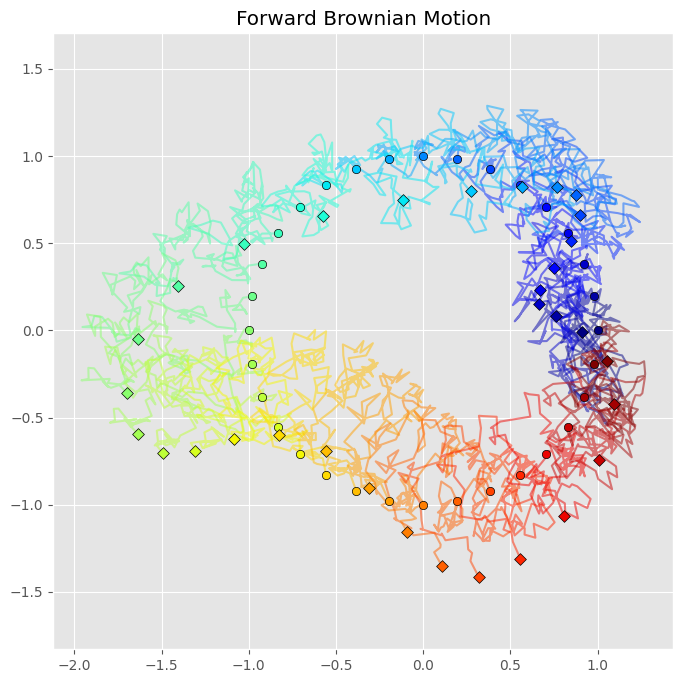

In [5]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=jax.random.PRNGKey(0),
    num_batches=1
)
print(forward_brownian_motion["trajectories"].shape)
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion")

In [6]:
XT = forward_brownian_motion["trajectories"][0][-1]

In [7]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 256, 128],
                "decoder_layer_dims": [128, 256, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng)

Training:   2%|▏         | 1/50 [00:18<14:54, 18.25s/epoch, Epoch=1, loss=261355280.0000]


KeyboardInterrupt: 

In [25]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

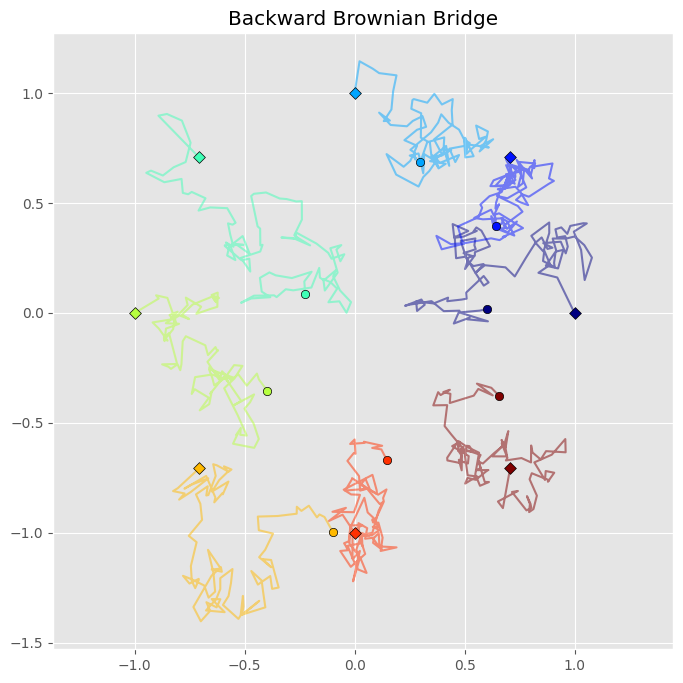

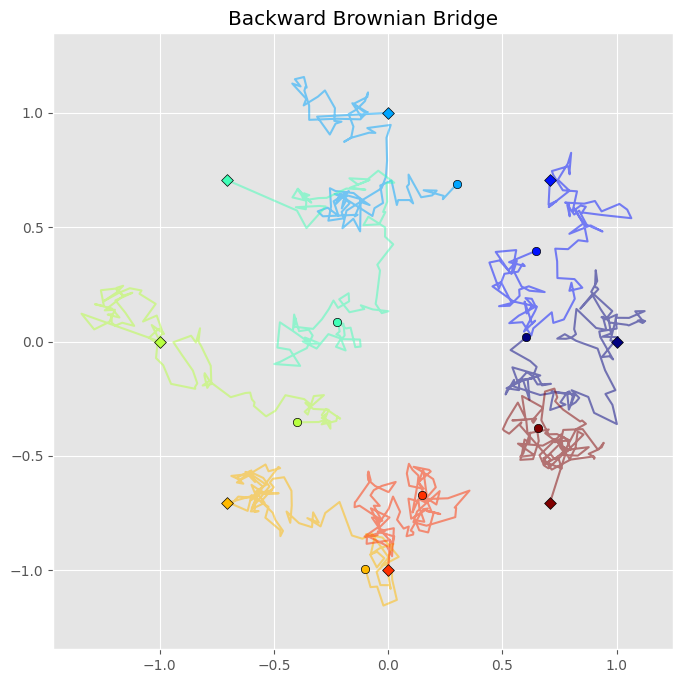

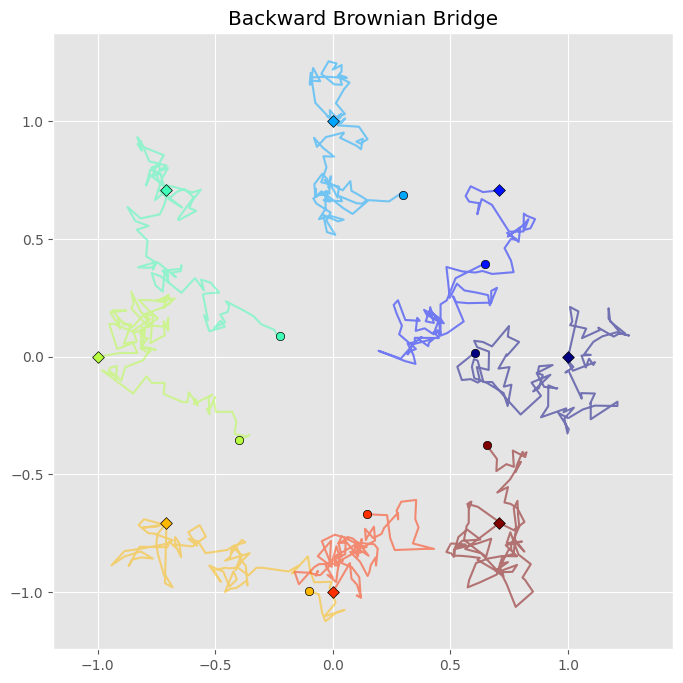

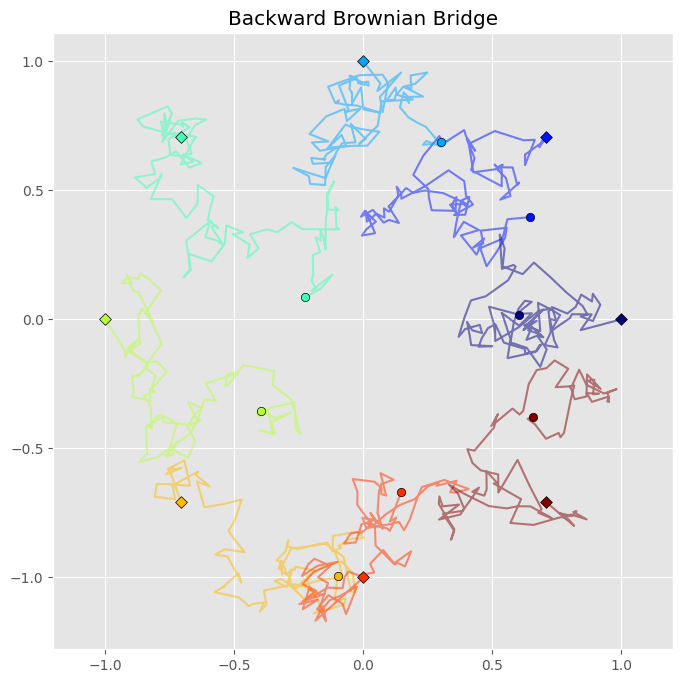

In [26]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [27]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 256, 128],
                "decoder_layer_dims": [128, 64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 100,
                 "learning_rate": 5e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 50/50 [04:13<00:00,  5.06s/epoch, Epoch=50, loss=7.4031]


In [28]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

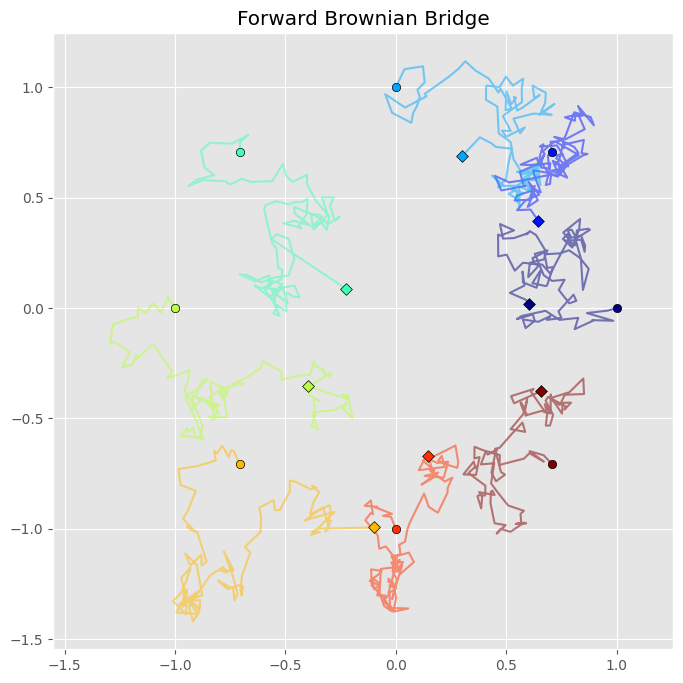

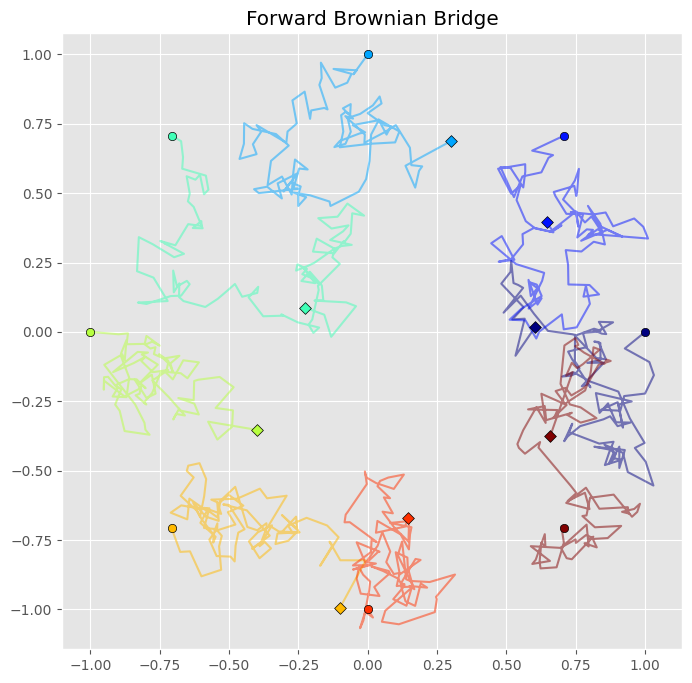

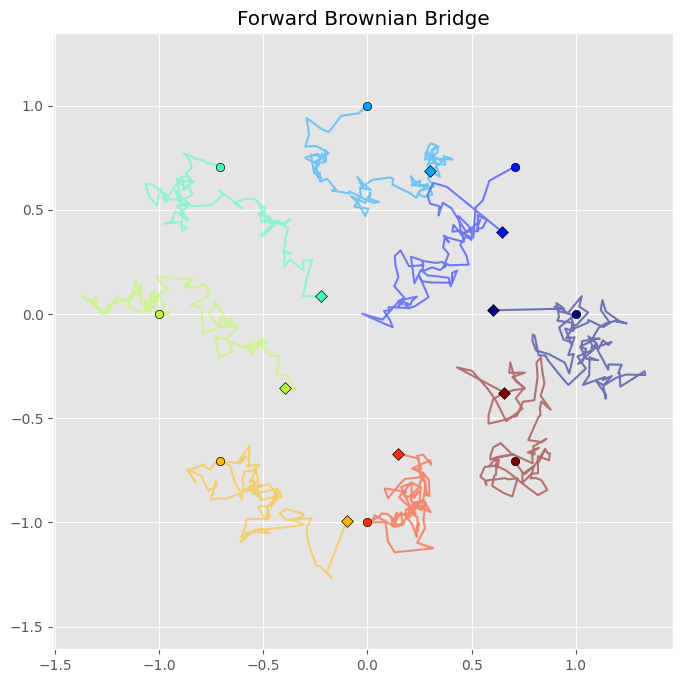

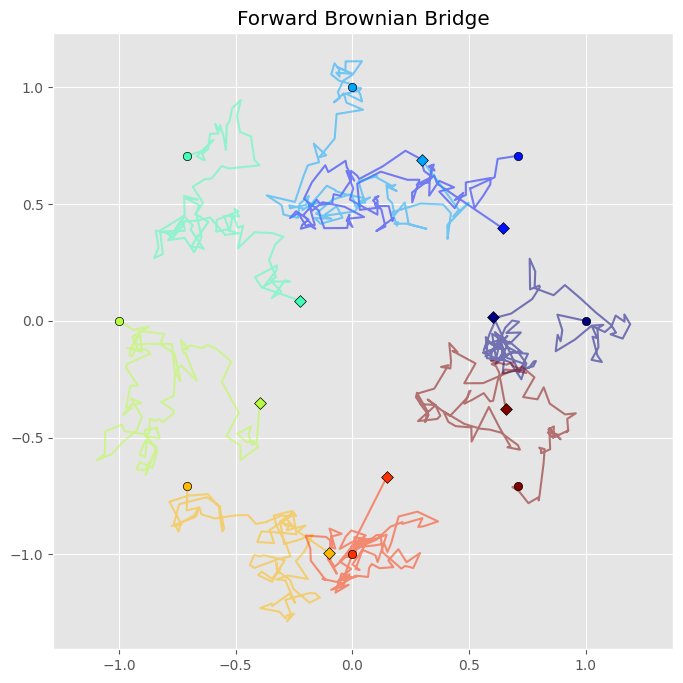

In [29]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Brownian Bridge")

### Variable Q

In [5]:
alpha = 0.5
sigma = 0.5

### 2 Landmarks

In [5]:
d = 4
sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0])

In [6]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=rng,
    num_batches=16
)

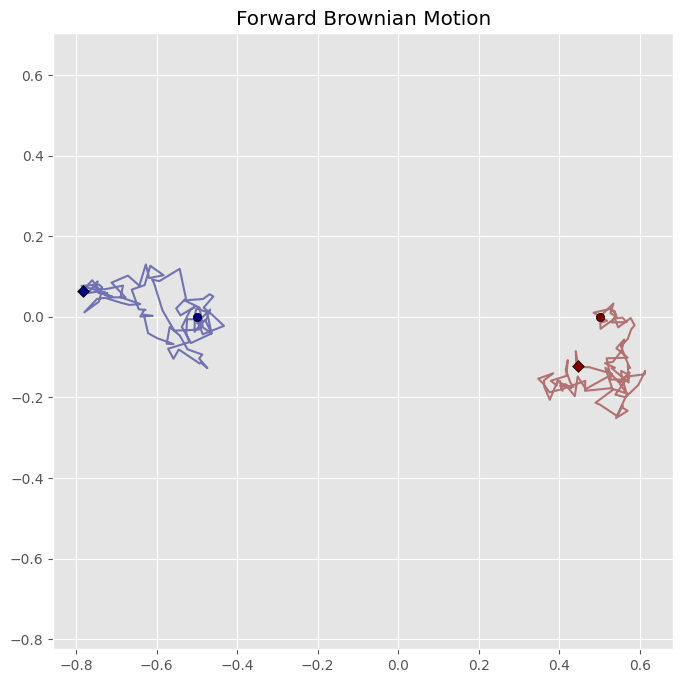

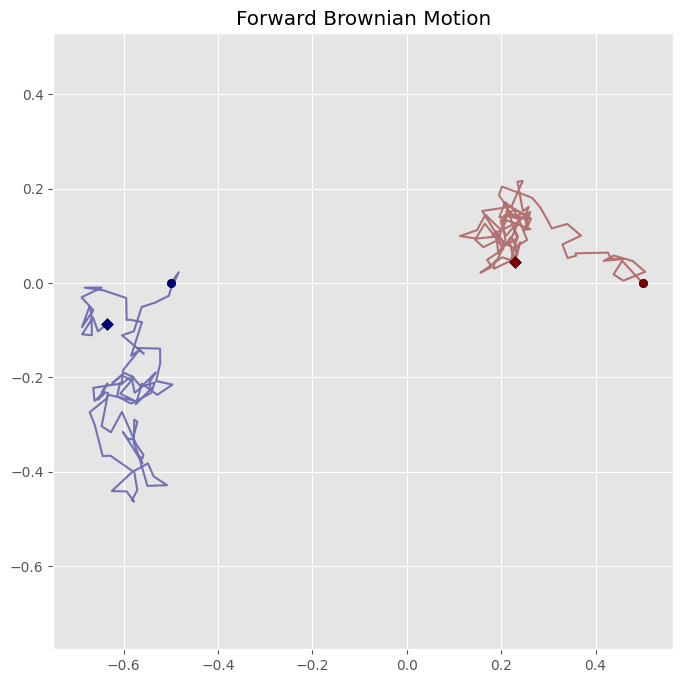

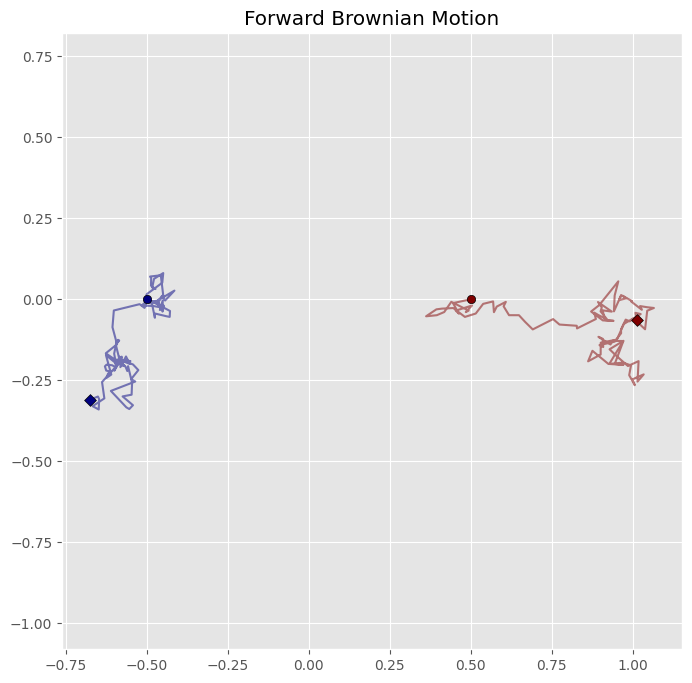

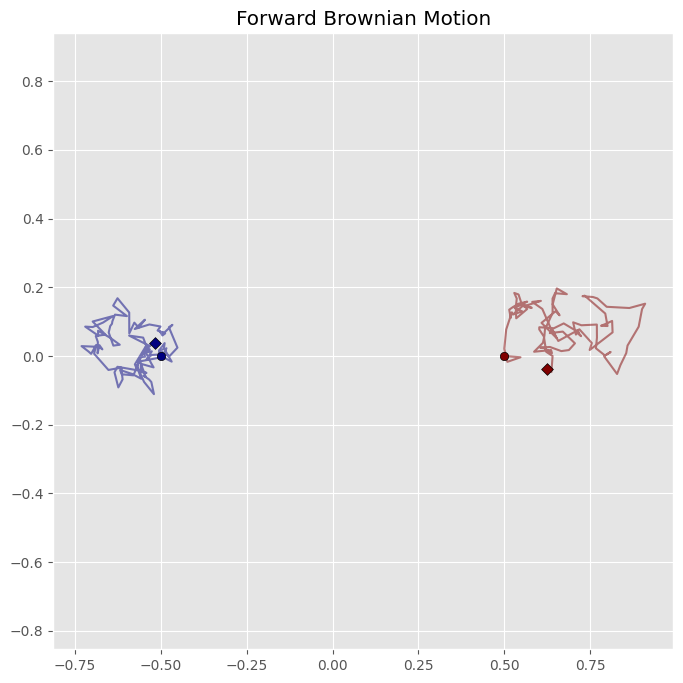

In [7]:
for i in range(4):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [8]:
XT = forward_brownian_motion["trajectories"][1][-1]

In [13]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [128, 64],
                "decoder_layer_dims": [64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 25,
                 "learning_rate": 5e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng)

Training: 100%|██████████| 50/50 [00:16<00:00,  3.11epoch/s, Epoch=50, loss=1.8795]


In [14]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

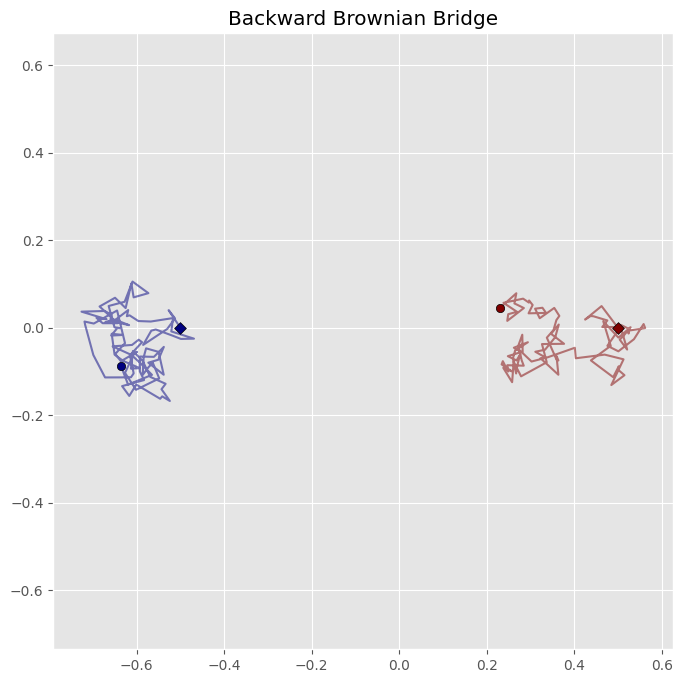

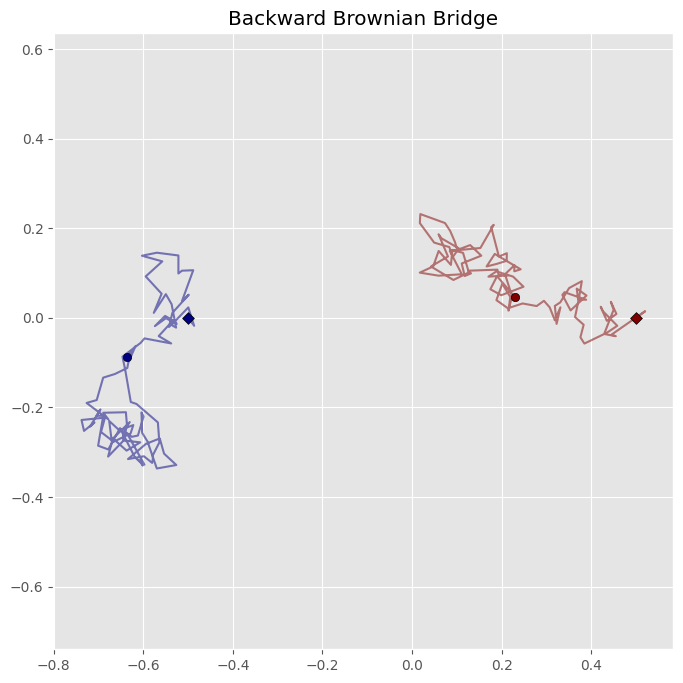

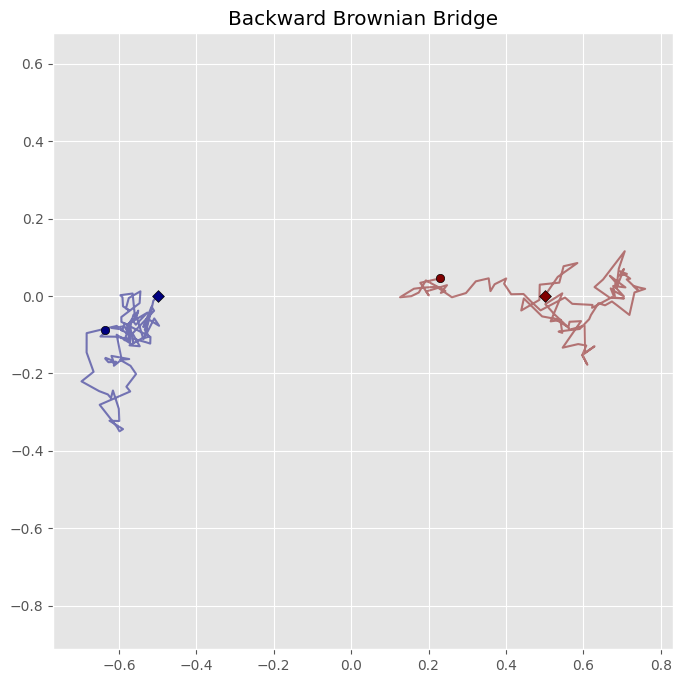

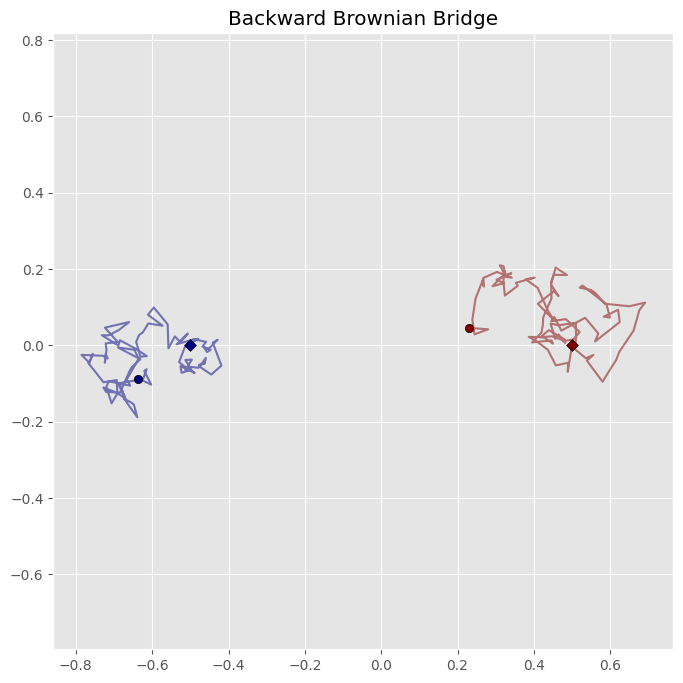

In [15]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")

In [16]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [128, 64],
                "decoder_layer_dims": [64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 25,
                 "learning_rate": 5e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng)

Training: 100%|██████████| 50/50 [00:17<00:00,  2.79epoch/s, Epoch=50, loss=1.7981]


In [17]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

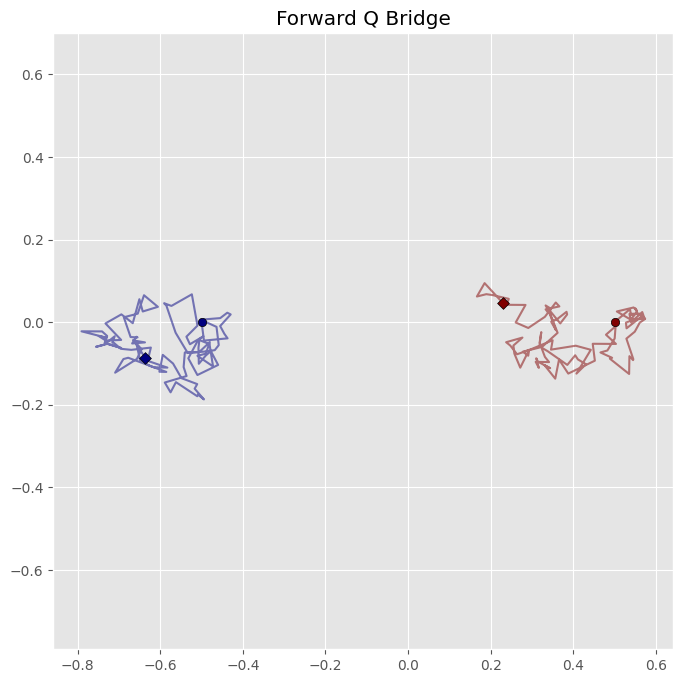

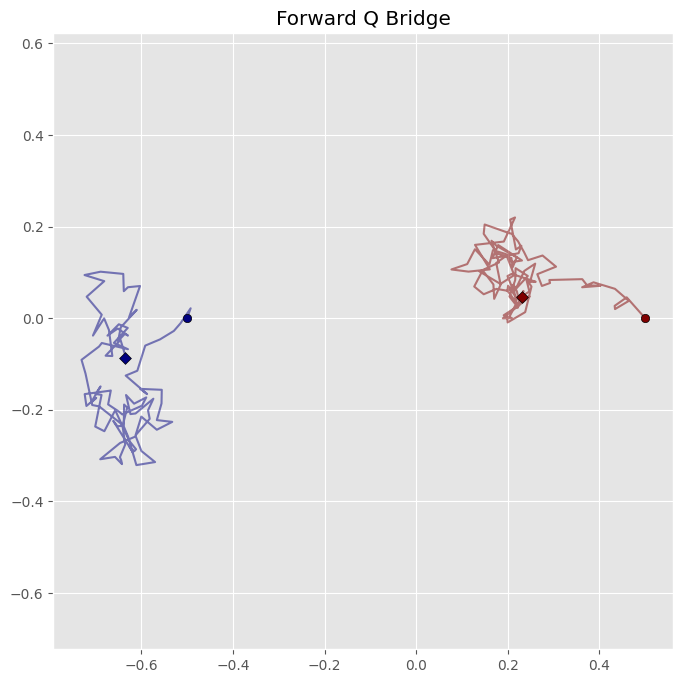

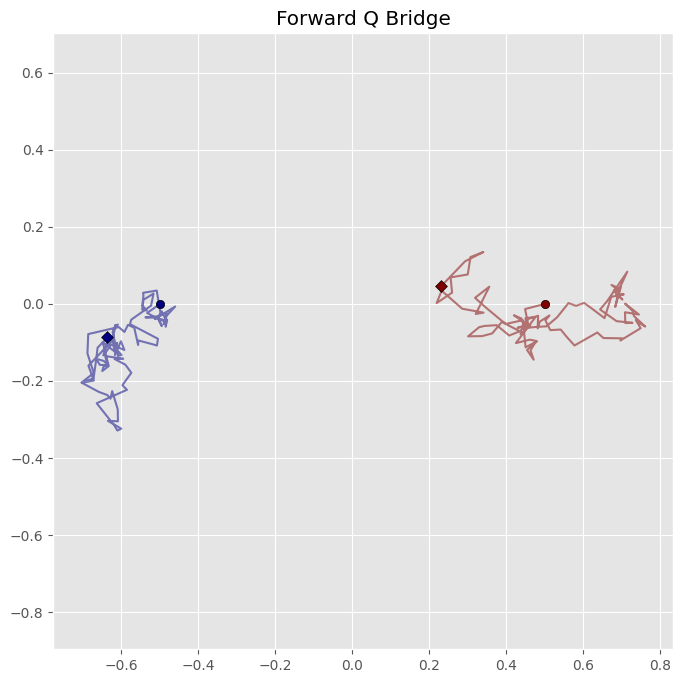

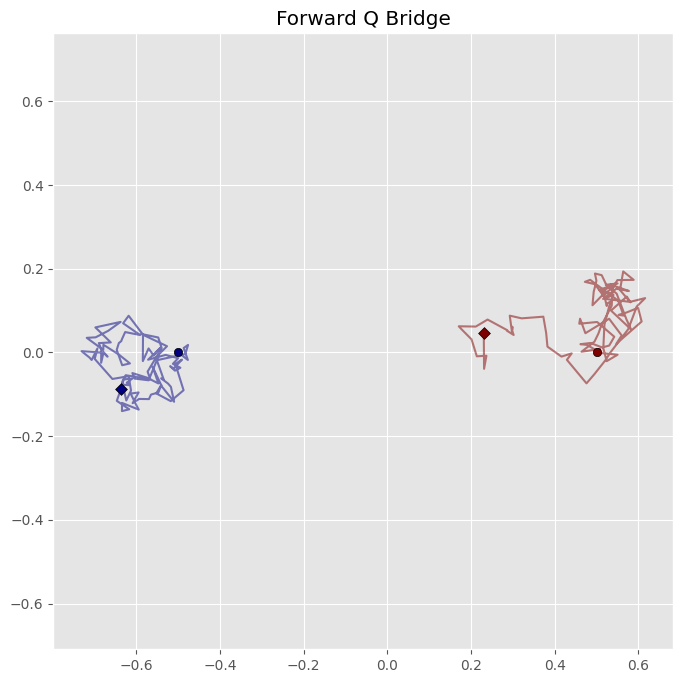

In [18]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

### More Landmarks

In [8]:
d = 64
sde_params = {
    "dimension": d,
    "num_steps": 200,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

X0 = jnp.array([-0.5, 0.0, 0.5, 0.0, 0.5, 1.0, -0.5, 1.0])

In [9]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=rng,
    num_batches=16
)

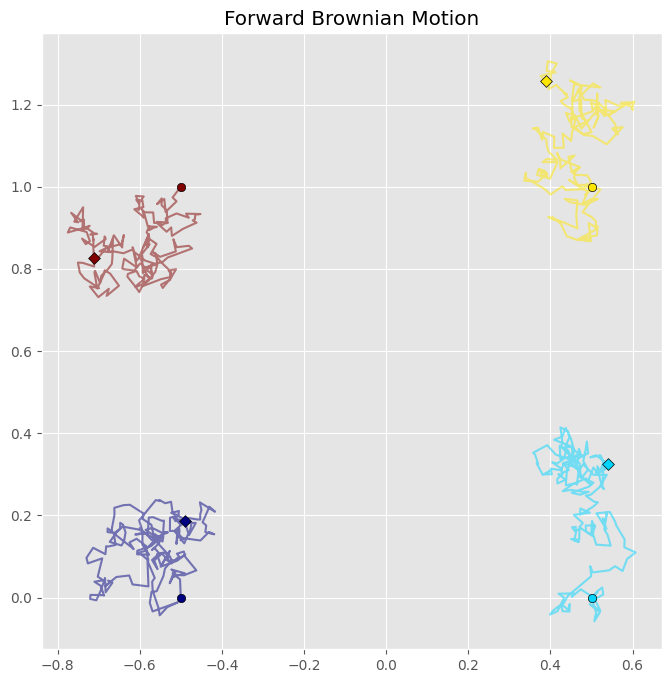

In [11]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

In [12]:
XT = forward_brownian_motion["trajectories"][1][-1]

In [13]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [128, 64],
                "decoder_layer_dims": [64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 25,
                 "learning_rate": 5e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng)

Training: 100%|██████████| 50/50 [00:32<00:00,  1.54epoch/s, Epoch=50, loss=3.8769]


In [14]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

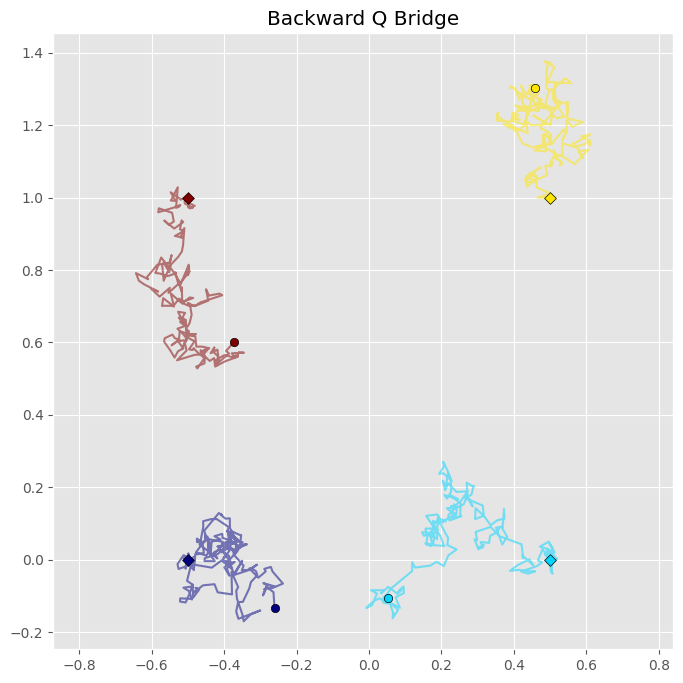

In [15]:
for i in range(1):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][-i], title="Backward Q Bridge")

In [20]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 256, 128],
                "decoder_layer_dims": [128, 64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng)

Training:   6%|▌         | 3/50 [00:18<04:45,  6.08s/epoch, Epoch=3, loss=357.5346]


KeyboardInterrupt: 

In [17]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

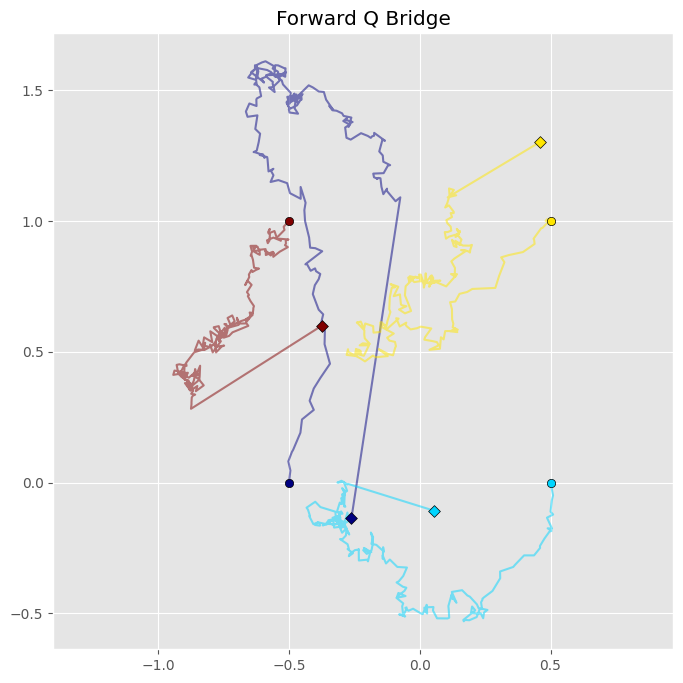

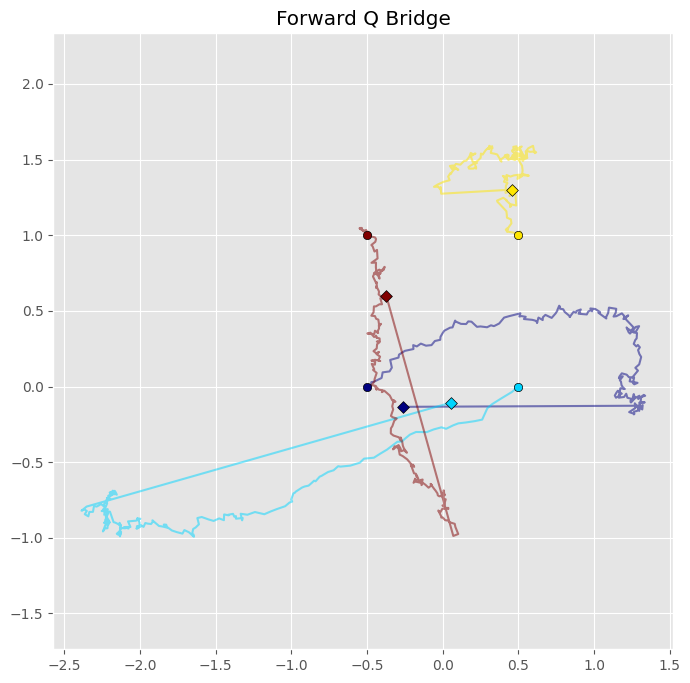

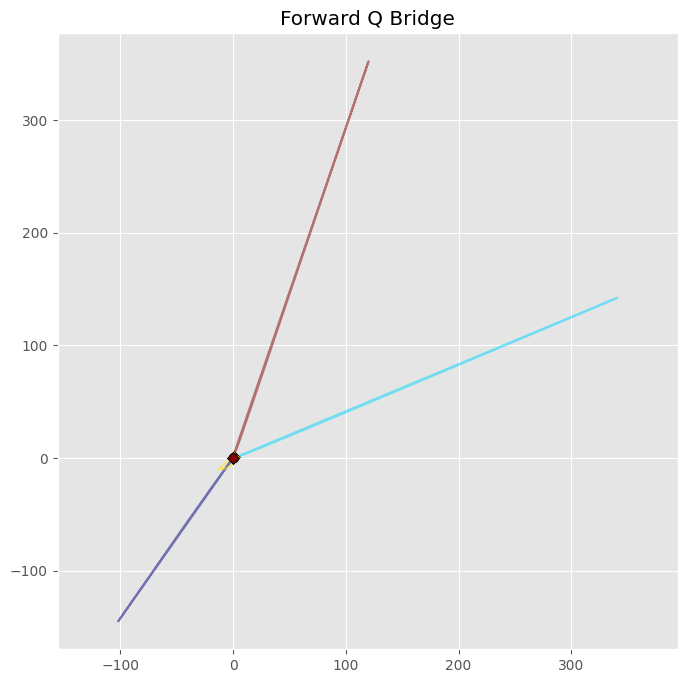

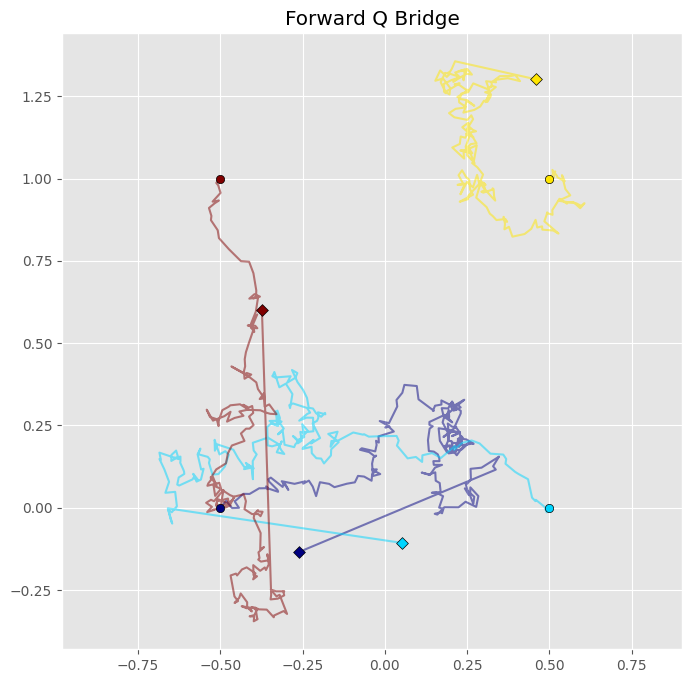

In [18]:
for i in range(4):
    plot_single_trajectory(forward_brownian_bridge["trajectories"][i], title="Forward Q Bridge")

In [19]:
d = 128
sigma = 0.5
sde_params = {
    "dimension": d,
    "num_steps": 200,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

In [20]:
X0 = sample_ellipse(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0)

forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=X0,
    rng=rng,
    num_batches=16
)

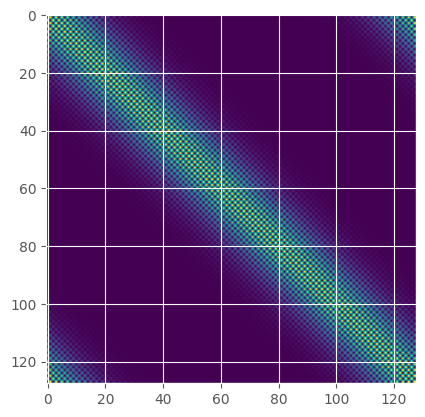

In [21]:
plt.imshow(eval_Q(X0, alpha, sigma))

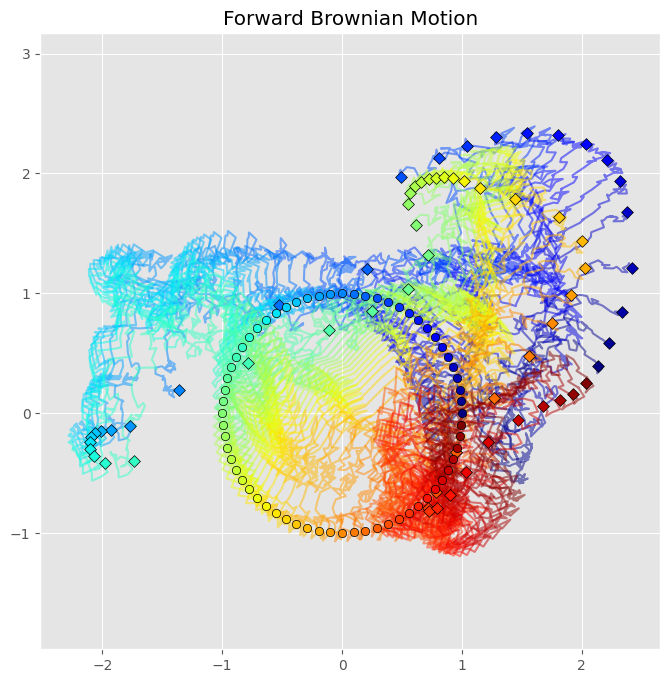

In [22]:
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion")

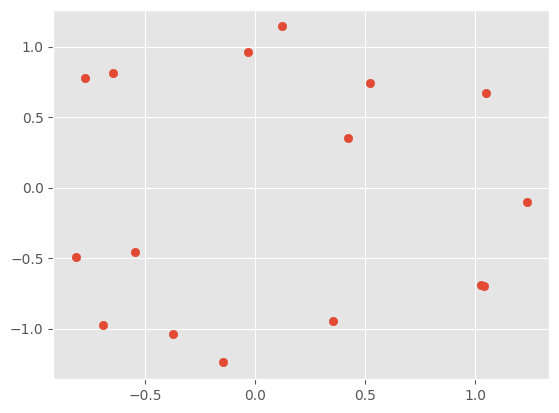

In [108]:
XT = forward_brownian_motion["trajectories"][1][-1]
plt.scatter(XT.reshape(-1, 2)[:, 0], XT.reshape(-1, 2)[:, 1])

In [109]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 256, 128],
                "decoder_layer_dims": [128, 64, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 25,
                 "learning_rate": 5e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 50/50 [04:46<00:00,  5.74s/epoch, Epoch=50, loss=15.8505]


In [111]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

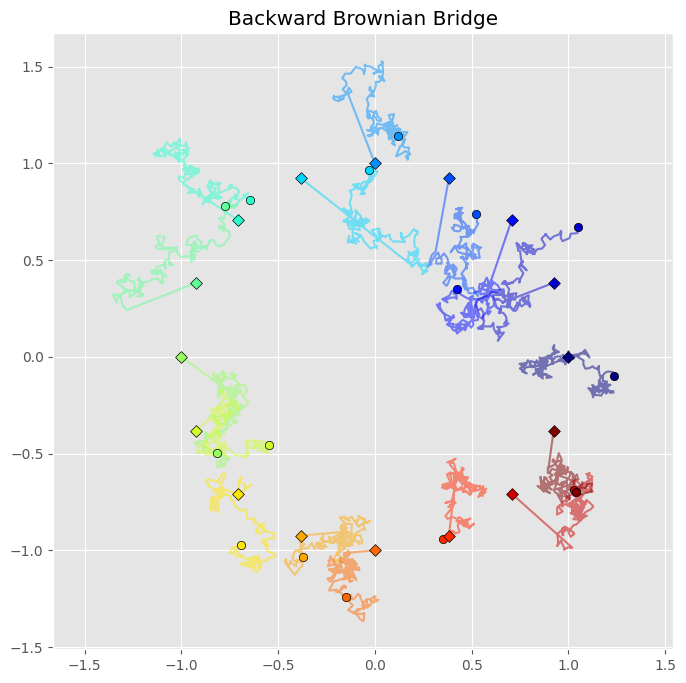

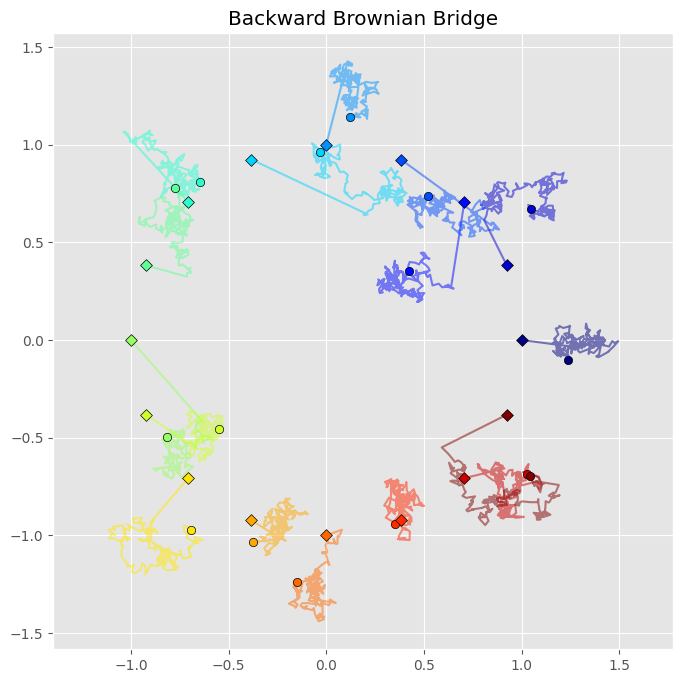

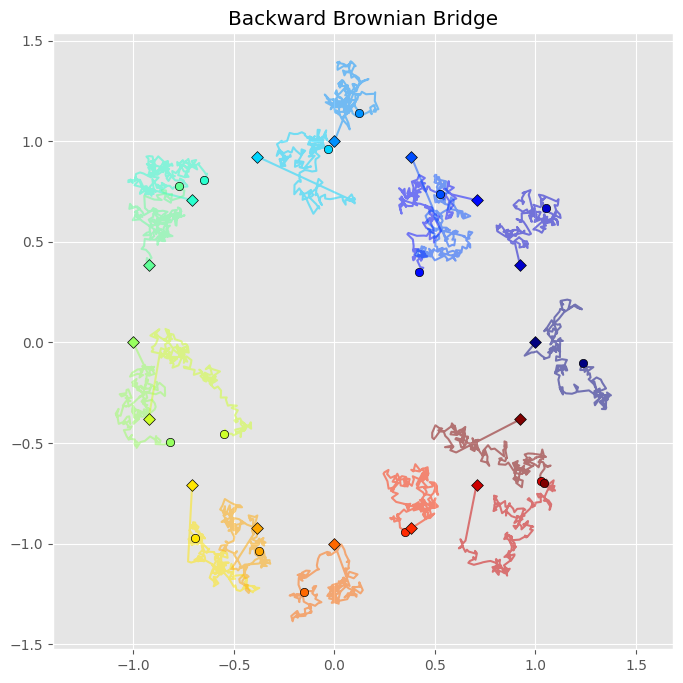

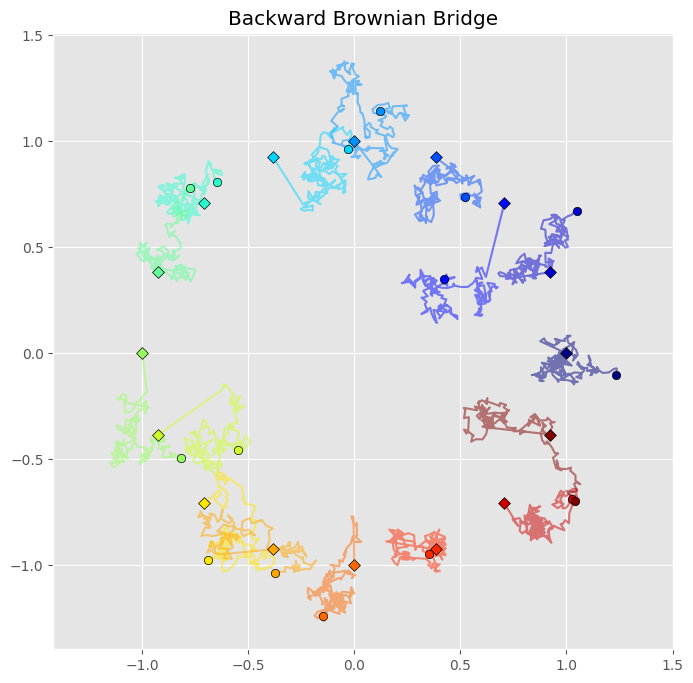

In [112]:
for i in range(4):
    plot_single_trajectory(backward_brownian_bridge["trajectories"][i], title="Backward Brownian Bridge")